In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import pickle
from tableone import TableOne
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, average_precision_score, precision_recall_curve

In [3]:
results = pd.read_csv('/local/scratch/zzaiman/CS334FinalProject/zach/runs/run1/results.csv')
admissions = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/admissions.csv')
patients = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/patients.csv')
# icu = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/icu/icustays.csv')

In [4]:
admissions_demo = admissions.filter(['subject_id', 'race', 'language','insurance', 'marital_status', 'hospital_expire_flag'], axis=1).drop_duplicates(subset='subject_id')

In [5]:
results = results.merge(admissions_demo, on='subject_id')
results = results.merge(patients, on='subject_id')
print(len(results.index)) #I GET A VERY SMALL NUMBER OF PATIENT RESULTS - WHY??
results.head()

5159


,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,race,language,insurance,marital_status,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10032725,50331901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,BLACK/AFRICAN AMERICAN,ENGLISH,Other,SINGLE,0,F,38,2143,2011 - 2013,2143-03-30
1,10032725,55504914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,BLACK/AFRICAN AMERICAN,ENGLISH,Other,SINGLE,0,F,38,2143,2011 - 2013,2143-03-30
2,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,WHITE,ENGLISH,Other,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04
3,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,WHITE,ENGLISH,Other,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04
4,10046166,51738740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,WHITE,ENGLISH,Other,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04


In [6]:
labels = 'Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices'.split(',')
labels = np.array(labels)

In [7]:
preds = pickle.load(open('/local/scratch/zzaiman/CS334FinalProject/zach/runs/run1/predictions', 'rb'))
hist = pickle.load(open('/local/scratch/zzaiman/CS334FinalProject/zach/runs/run1/train_hist', 'rb'))

### Insurance

In [8]:
results['insurance'].value_counts()

Medicare    2909
Other       1939
Medicaid     311
Name: insurance, dtype: int64

A patient's insurance provider can often overlap with the patient's socioeconomic status and/or age and therefore health outcomes. For example, low-income individuals are eligible to receive Medicaid, while patients who have Medicare as their insurance provider are either over 65 or have disabilitiess. "Other" refers to private insurance which is connected to active employment and/or higher income.

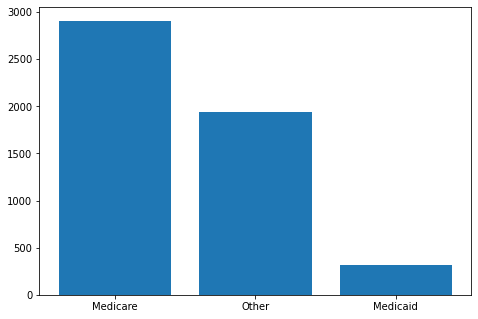

In [9]:
insurance_dist = results['insurance'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(insurance_dist.index, insurance_dist.values)
plt.show()

#!! HAS MUCH LOWER NUMBERS

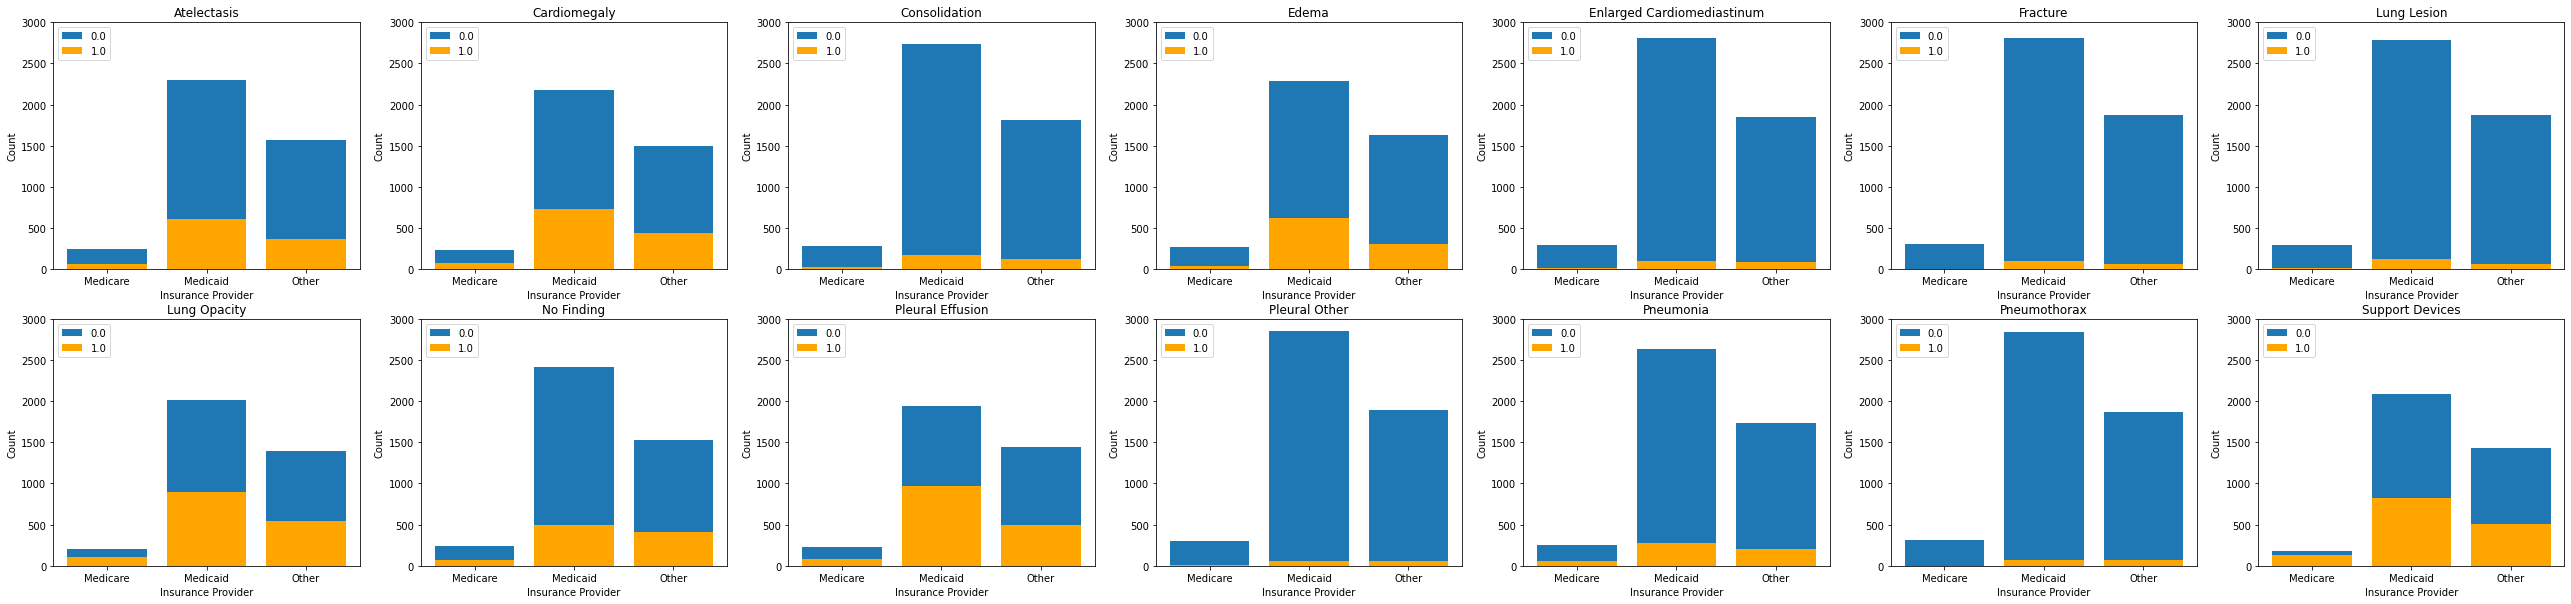

In [10]:
from matplotlib import ticker
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
insurance = ['Medicare', 'Medicaid', 'Other']
positions = [0,1,2]
for i, lab in enumerate(labels):
    if i < 7:
        x = 0
    else:
        x = 1
    if i < 7:
        y = i
    else:
        y = i - 7

    a = pd.DataFrame({'count': results.groupby([lab, 'insurance']).size()}).reset_index()
    neg_df = a[a[lab] == 0.0].iloc[:, 1:]
    pos_df = a[a[lab] == 1.0].iloc[:, 1:]
    ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
    ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
    ax[x, y].title.set_text(lab)
    ax[x, y].legend(loc=2)
    ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(insurance))
    ax[x, y].set_xticklabels(insurance)
    ax[x, y].set_xlabel('Insurance Provider')
    ax[x, y].set_ylabel('Count')
    ax[x, y].set_ylim(0,3000)

_Initial observation: Medicaid people have a disproportionate number of support devices (more than half). They also seem to have disproportionately low Edema._

In [11]:
#I used Niki's code here to see if there is any relation btw/ model accuracy and insurance type

# Helper functions for evaluating model performance
# Generate 95% Confidence Intervals for each AUC score
def generate_CI(y_true, y_pred):

    n_bootstraps = 1000
    rng_seed = 2021  
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    #95% confidence interval
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    ci_str = '[{}, {}]'.format(str(round(confidence_lower, 3)), str(round(confidence_upper, 3)))
    return ci_str

# Calculate and plot ROC
def calc_roc(df, strata, labels):
    fpr = {}
    tpr = {}
    auc = {}
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7
        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ci = generate_CI(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)} ci={ci}')
        for category in df[strata].unique():
            tmp = df[df[strata] == category].reset_index(drop=True)
            ytrue = tmp[lab]
            print(ytrue.nunique())
            ypred = tmp['pred_'+lab]
            tfpr, ttpr, _ = roc_curve(ytrue, ypred)
            tauc = roc_auc_score(ytrue, ypred)
            fpr[str(category) + '_' + lab] = tfpr
            tpr[str(category) + '_' + lab] = ttpr
            auc[str(category) + '_' + lab] = tauc
            tci = generate_CI(ytrue, ypred)
            ax[x, y].plot(tfpr, ttpr, label=f'{str(category)} auc={round(tauc, 2)}, ci={tci}')
            ax[x, y].title.set_text(lab)
            ax[x, y].legend(loc=4)
            ax[x, y].set_xlabel('FPR')
            ax[x, y].set_ylabel('TPR')

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


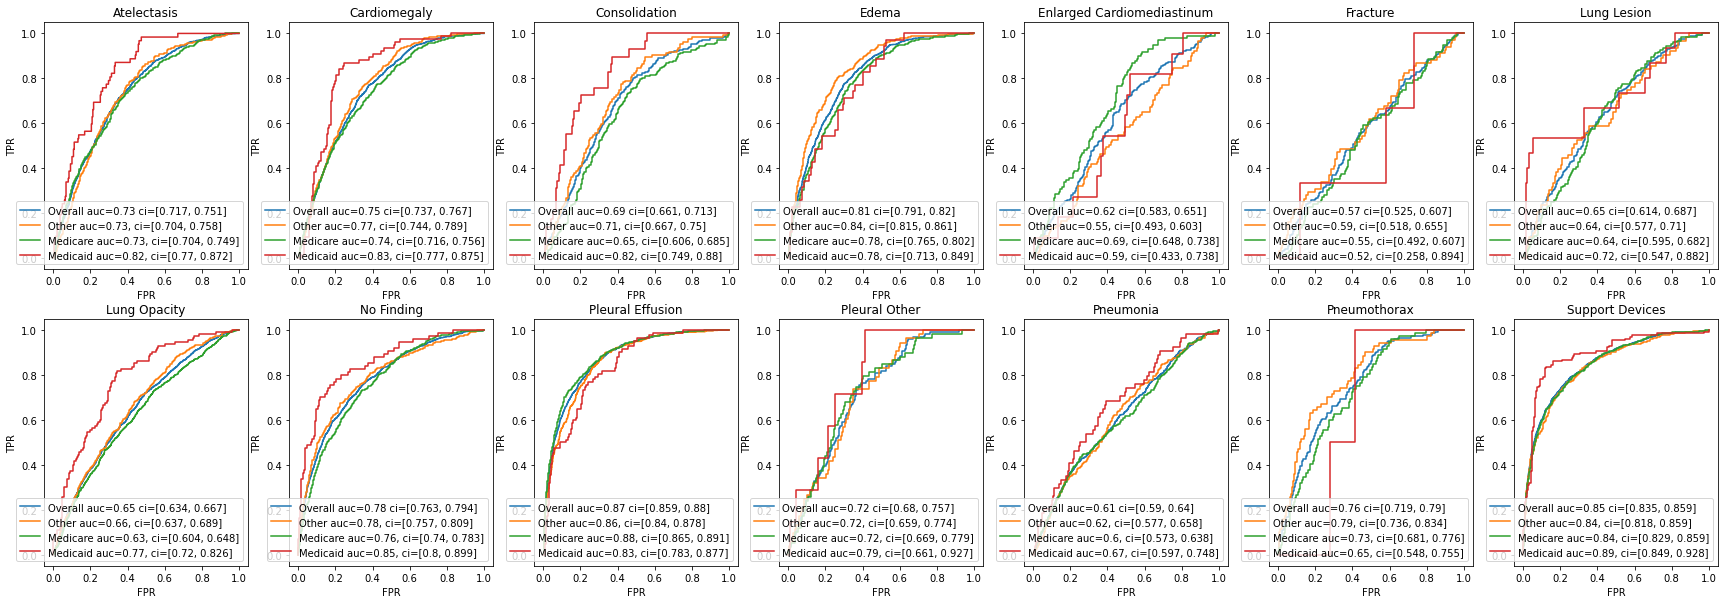

In [12]:
calc_roc(results, 'insurance', labels)

_Initial observations: Model performs better for medicaid patients, except for Edema, Pleural Effusion, and labels with very few positive instances._

We can use Pearson Correlation to assess the correlation between a specific insurance provider and diagnosis

In [36]:
#Convert each insurance to a binary category
def isMedicare(x):
    if x['insurance'] == 'Medicare':
        return 1.0
    else: return 0.0

def isMedicaid(x):
    if x['insurance'] == 'Medicaid':
        return 1.0
    else: return 0.0

def isOther(x):
    if x['insurance'] != 'Medicare' and x['insurance'] != 'Medicaid':
        return 1.0
    else: return 0.0

In [37]:
insurance_df = results.copy()
insurance_df['isMedicare'] = insurance_df.apply(lambda row: isMedicare(row), axis=1)
insurance_df['isMedicaid'] = insurance_df.apply(lambda row: isMedicaid(row), axis=1)
insurance_df['isOther'] = insurance_df.apply(lambda row: isOther(row), axis=1)
insurance_df


,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,age_cohort,isMedicare,isMedicaid,isOther
0,10032725,50331901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,F,38,2143,2011 - 2013,2143-03-30,30-39,0.0,0.0,1.0
1,10032725,55504914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,F,38,2143,2011 - 2013,2143-03-30,30-39,0.0,0.0,1.0
2,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,M,67,2132,2011 - 2013,2133-11-04,60-69,0.0,0.0,1.0
3,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,M,67,2132,2011 - 2013,2133-11-04,60-69,0.0,0.0,1.0
4,10046166,51738740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,M,67,2132,2011 - 2013,2133-11-04,60-69,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5154,19991135,58283482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,F,57,2124,2008 - 2010,2133-07-19,50-59,1.0,0.0,0.0
5155,19991135,58283482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,F,57,2124,2008 - 2010,2133-07-19,50-59,1.0,0.0,0.0
5156,19991135,58283482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,F,57,2124,2008 - 2010,2133-07-19,50-59,1.0,0.0,0.0
5157,19991135,59381316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,F,57,2124,2008 - 2010,2133-07-19,50-59,1.0,0.0,0.0


In [38]:
from scipy.stats import pearsonr

insurance_labels = ['isMedicare', 'isMedicaid', 'isOther']

insurance_corr_dict = dict()
for ins_lab in insurance_labels:
    ins_lab_dict = dict()

    for diag in labels:

        x = insurance_df[ins_lab]
        y = insurance_df[diag]

        corr, _ = pearsonr(x, y)
        ins_lab_dict[diag] = corr

    insurance_corr_dict[ins_lab] = dict(sorted(ins_lab_dict.items(), key=lambda item: item[1]))

insurance_corr_dict

{'isMedicare': {'No Finding': -0.060536351423183504,
  'Enlarged Cardiomediastinum': -0.02991454329196615,
  'Pneumonia': -0.02801780000533139,
  'Pneumothorax': -0.02182418711992641,
  'Pleural Other': -0.02109213306606314,
  'Consolidation': -0.017384570811005213,
  'Support Devices': 0.0012528389927272754,
  'Fracture': 0.004050217995044311,
  'Lung Opacity': 0.017698849819930248,
  'Lung Lesion': 0.02035039238891173,
  'Atelectasis': 0.02339417317927568,
  'Cardiomegaly': 0.02517177543071304,
  'Edema': 0.0796280116629945,
  'Pleural Effusion': 0.08497093202536292},
 'isMedicaid': {'Edema': -0.047755343413844645,
  'Pneumothorax': -0.03303031145688725,
  'Fracture': -0.03252068166985535,
  'Pleural Effusion': -0.019491934637617905,
  'Enlarged Cardiomediastinum': -0.004457615757466844,
  'Pleural Other': -0.0009422318069671397,
  'Atelectasis': -0.0006766803068894772,
  'Cardiomegaly': 0.0003110144500311337,
  'Lung Lesion': 0.011852342836838696,
  'Lung Opacity': 0.028185188183274

This does not return a strong correlation between any insurance provider and medical diagnosis. But let's plot in anyway.

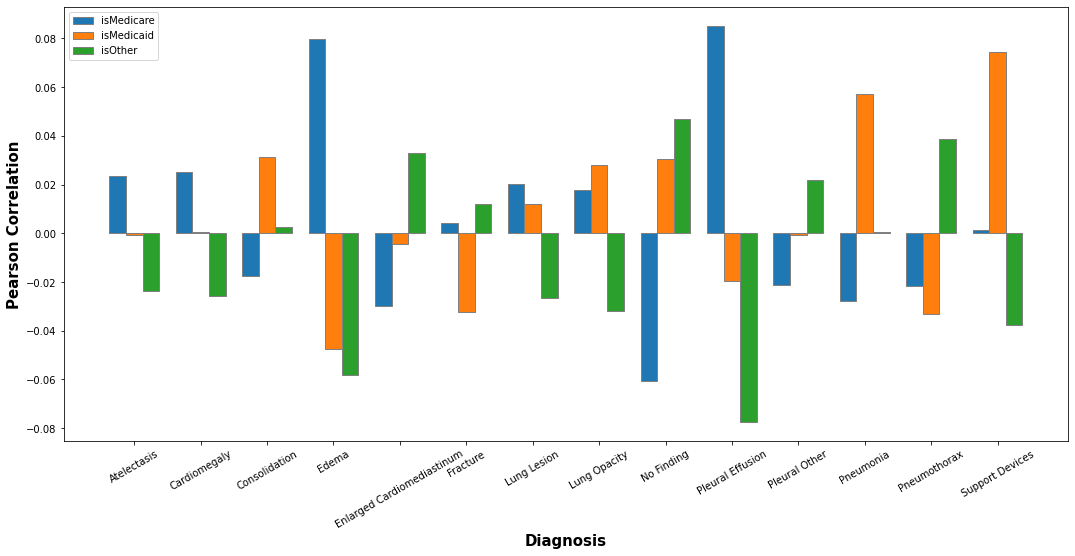

In [53]:
barWidth = 0.25
fig = plt.subplots(figsize =(18, 8))

lab_ins_corr_list = []

for i, ins in enumerate(insurance_corr_dict):

    correlations = []

    for diag in labels:

        correlations.append(insurance_corr_dict[ins][diag])
    
    lab_ins_corr_list.append(correlations)

    plt.bar(np.arange(i*barWidth, (i*barWidth)+len(labels)), correlations, width = barWidth, edgecolor ='grey', label=ins)

plt.xlabel('Diagnosis', fontweight ='bold', fontsize = 15)
plt.ylabel('Pearson Correlation', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(labels))], labels, rotation=30)
plt.legend()
plt.show()
    



### Age

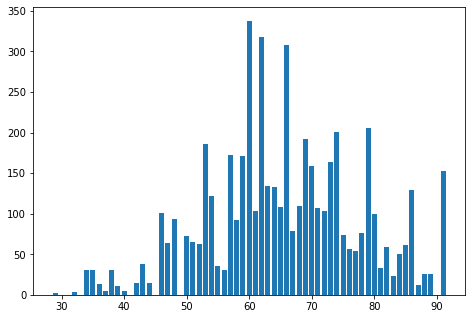

In [13]:
age_dist = results['anchor_age'].value_counts().sort_index()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(age_dist.index, age_dist.values)
plt.show()

Age can be correlated with many health outcomes. "Anchor age" provided in this dataset is not exact but roughly reflects (~2 years) the patient's age for the purpose of anonymization. All patients older than 89 years have 91 as their anchor age, which explains the relatively high incident of that age in the distribution. Since this is hospital patient data, the age distribution skews older.

In [14]:
def age_groups(x):
    if x['anchor_age'] < 20:
        return '10-19'
    if x['anchor_age'] < 30:
        return '20-29'
    if x['anchor_age'] < 40:
        return '30-39'
    if x['anchor_age'] < 50:
        return '40-49'
    if x['anchor_age'] < 60:
        return '50-59'
    if x['anchor_age'] < 70:
        return '60-69'
    if x['anchor_age'] < 80:
        return '70-79'
    if x['anchor_age'] < 90:
        return '80-89'
    else: return '90+'

results['age_cohort'] = results.apply(lambda row: age_groups(row), axis=1)
age_cohort_dist = results['age_cohort'].value_counts().sort_index()
    

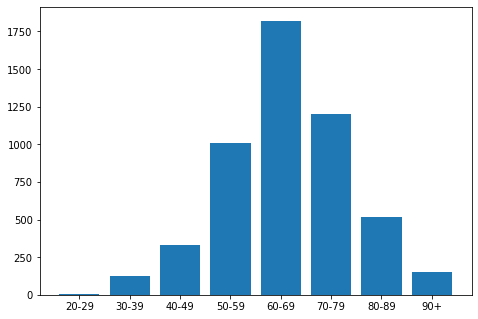

In [15]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(age_cohort_dist.index, age_cohort_dist.values)
plt.show()

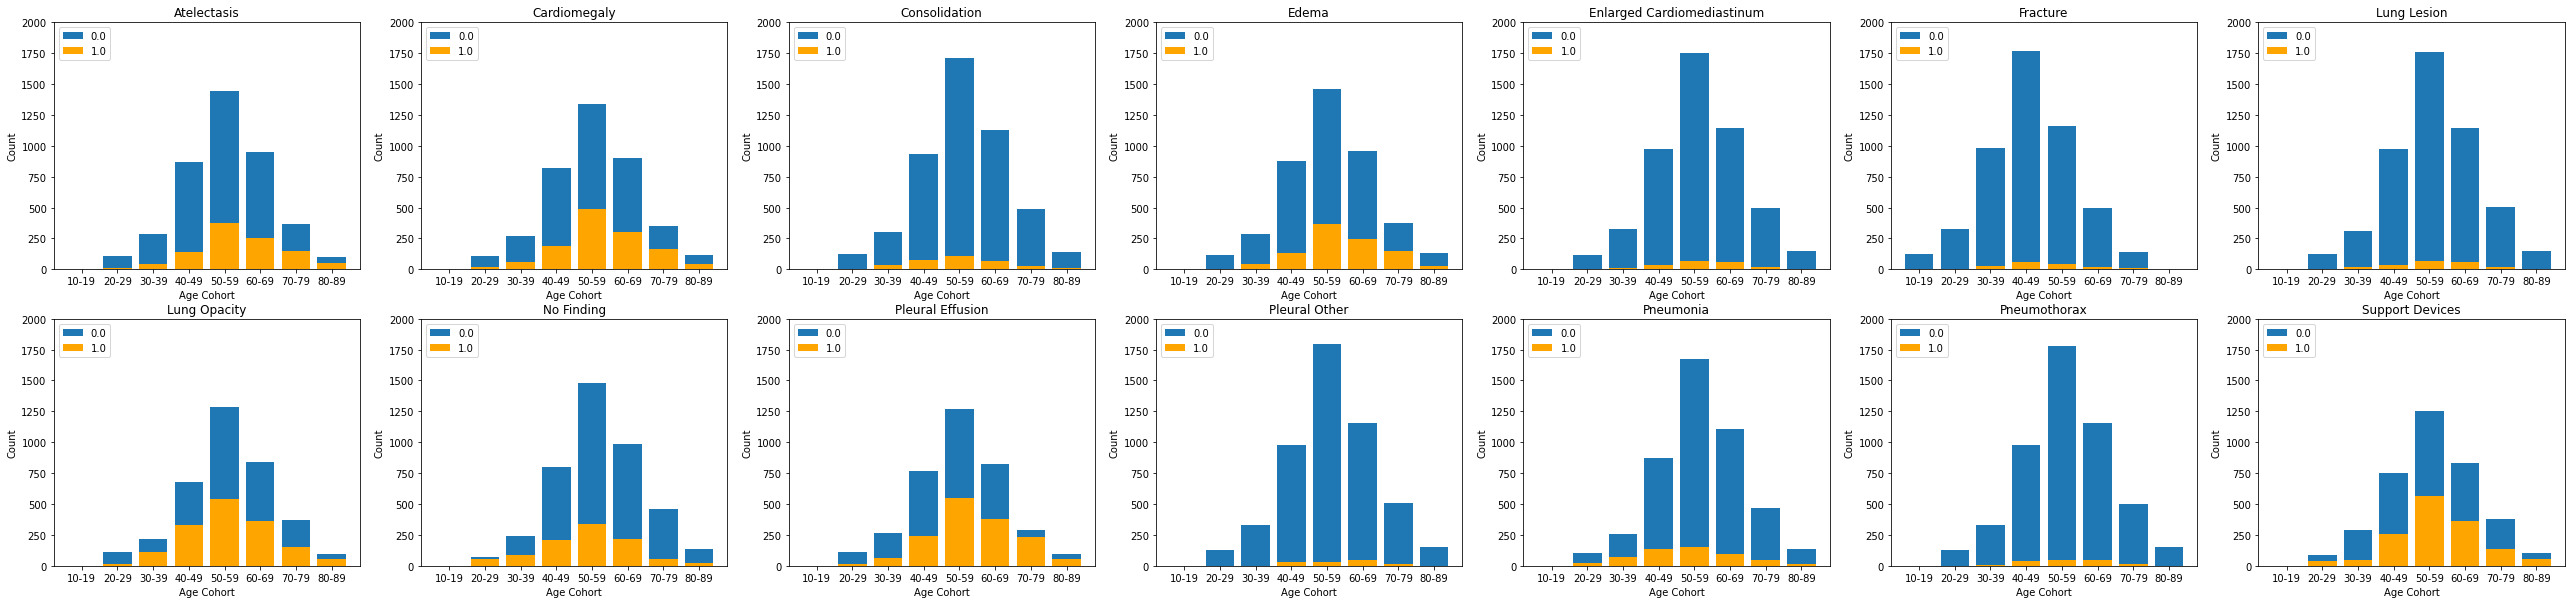

In [16]:
from matplotlib import ticker
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
cohort = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
positions = [0,1,2,3,4,5,6,7,8]
for i, lab in enumerate(labels):
    if i < 7:
        x = 0
    else:
        x = 1
    if i < 7:
        y = i
    else:
        y = i - 7

    a = pd.DataFrame({'count': results.groupby([lab, 'age_cohort']).size()}).reset_index()
    neg_df = a[a[lab] == 0.0].iloc[:, 1:]
    pos_df = a[a[lab] == 1.0].iloc[:, 1:]
    ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
    ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
    ax[x, y].title.set_text(lab)
    ax[x, y].legend(loc=2)
    ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(cohort))
    ax[x, y].set_xticklabels(cohort)
    ax[x, y].set_xlabel('Age Cohort')
    ax[x, y].set_ylabel('Count')
    ax[x, y].set_ylim(0,2000)

_Initial observations: Label "No Finding" is disproportinately common for younger age cohorts. Pleural Effusion id disproportinately common for older age cohorts._

2
2
2
2
2
2
2
1


/home/mazbay/cs334/CS334FinalProject/.venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

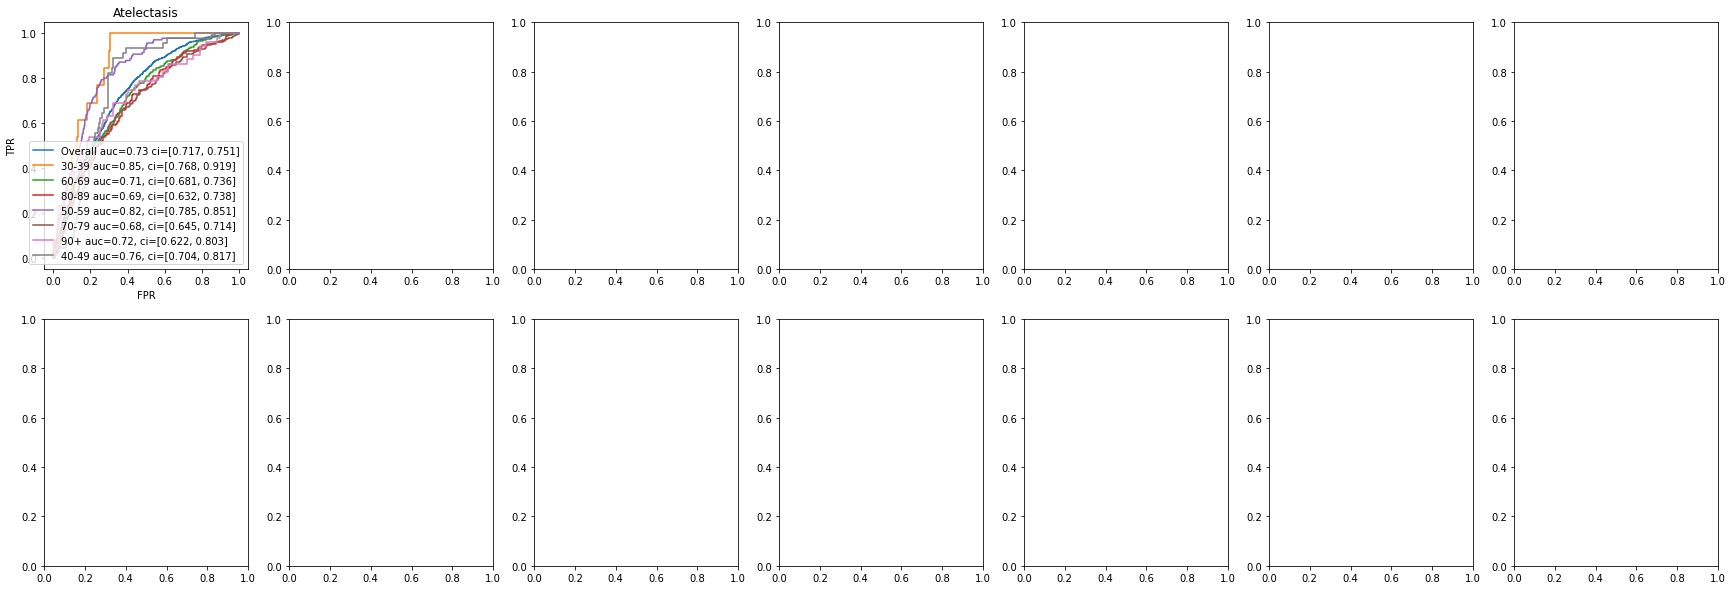

In [17]:
calc_roc(results, 'age_cohort', labels)

In [18]:
#Try making age cohorts of equal size
def build_equal_cohorts(df, age_count, num_cohorts):

    total_size = len(df.index)
    
    cohort_size = total_size/num_cohorts


    curr_cohort_size = 0
    cohort_name = ''
    isNewCohort = True
    cohorts = []
    lower_bound = -1
    upper_bound = -1        
    for age, count in age_count.iteritems():
        if isNewCohort:
            cohort_name = str(age) + '-'
            lower_bound = age
            isNewCohort = False
        curr_cohort_size += count
    
        if curr_cohort_size > cohort_size:
            upper_bound = age
            cohort_name += str(age)
            cohorts.append((cohort_name, lower_bound, upper_bound))
            curr_cohort_size = 0
            isNewCohort = True

    if len(cohorts)<num_cohorts:
        cohort_name += str(age_dist.index[-1])
        cohorts.append((cohort_name , lower_bound, age_dist.index[-1]))
    return cohorts  

In [19]:
num_cohorts = 7
equal_age_dist = build_equal_cohorts(results, age_dist, num_cohorts)
equal_age_dist

[('29-53', 29, 53),
 ('54-60', 54, 60),
 ('61-65', 61, 65),
 ('66-70', 66, 70),
 ('71-77', 71, 77),
 ('78-87', 78, 87),
 ('88-91', 88, 91)]

In [20]:
def equal_age_groups(x, equal_age_dist):
    if x['anchor_age'] <= equal_age_dist[0][2]:
        return equal_age_dist[0][0]
    if x['anchor_age'] <= equal_age_dist[1][2]:
        return equal_age_dist[1][0]
    if x['anchor_age'] <= equal_age_dist[2][2]:
        return equal_age_dist[2][0]
    if x['anchor_age'] <= equal_age_dist[3][2]:
        return equal_age_dist[3][0]
    if x['anchor_age'] <= equal_age_dist[4][2]:
        return equal_age_dist[4][0]
    if x['anchor_age'] <= equal_age_dist[5][2]:
        return equal_age_dist[5][0]
    else: return equal_age_dist[6][0]


results_2 = results.copy()
results_2['age_cohort'] = results_2.apply(lambda row: equal_age_groups(row, equal_age_dist), axis=1)
equal_age_cohort_dist = results_2['age_cohort'].value_counts().sort_index()
equal_age_cohort_dist

29-53    843
54-60    960
61-65    796
66-70    848
71-77    760
78-87    748
88-91    204
Name: age_cohort, dtype: int64

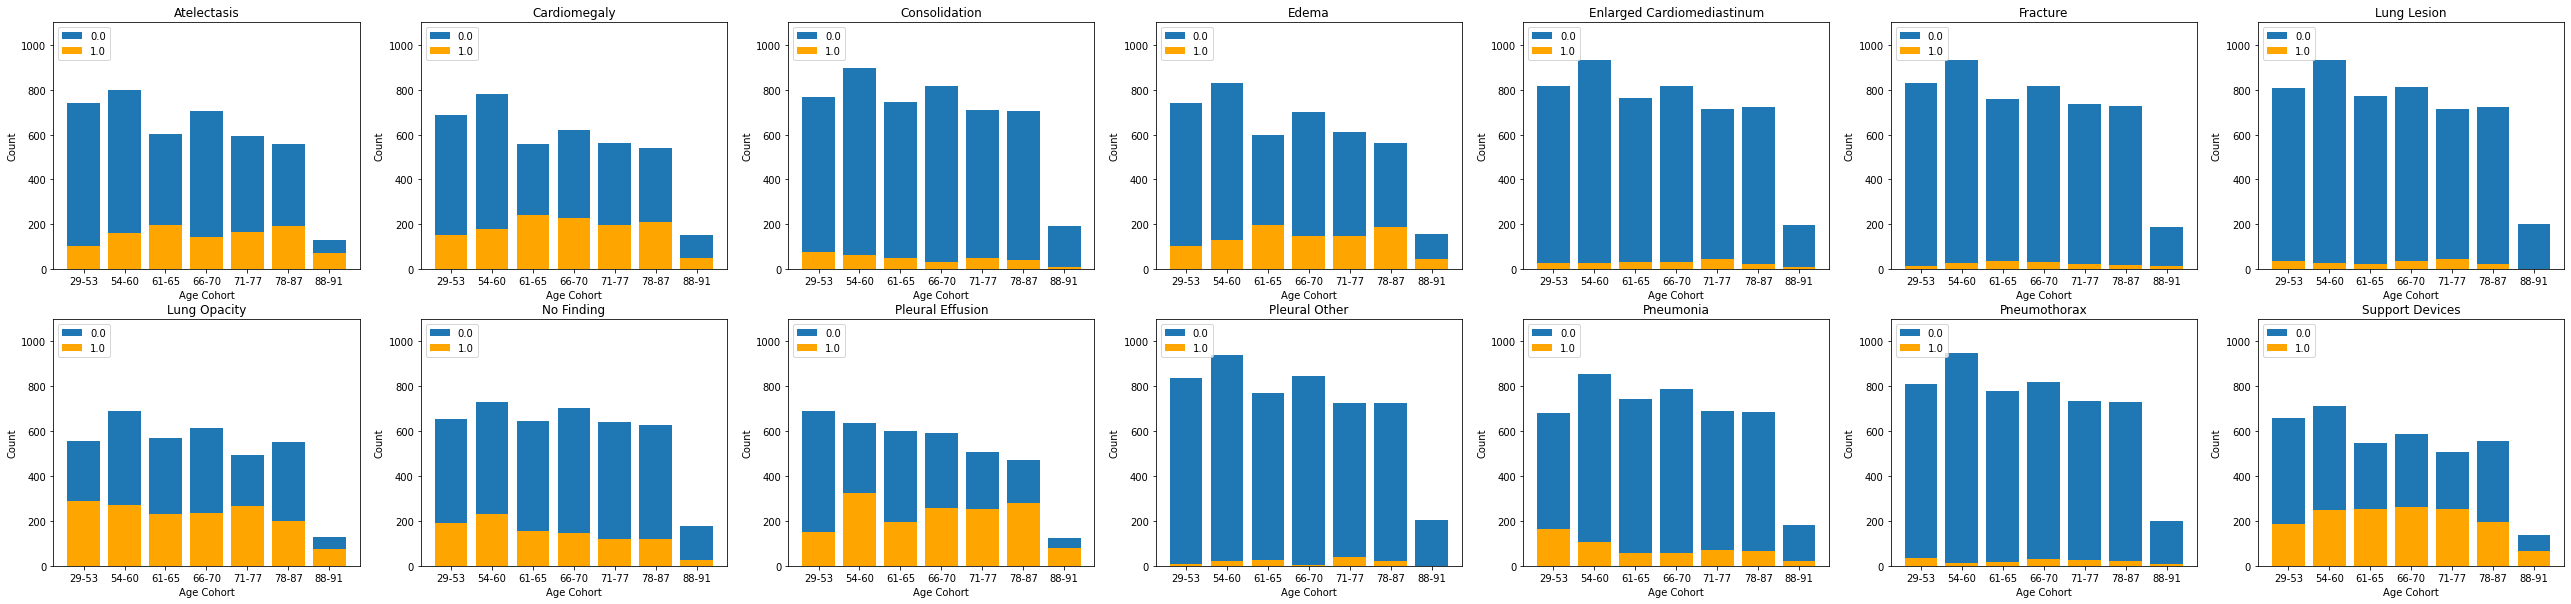

In [21]:
from matplotlib import ticker
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
cohorts = [x[0] for x in equal_age_dist]
# print(cohorts)
positions = [i for i in range(0, num_cohorts)]
# print(positions)
for i, lab in enumerate(labels):
    if i < 7:
        x = 0
    else:
        x = 1
    if i < 7:
        y = i
    else:
        y = i - 7

    a = pd.DataFrame({'count': results_2.groupby([lab, 'age_cohort']).size()}).reset_index()
    neg_df = a[a[lab] == 0.0].iloc[:, 1:]
    pos_df = a[a[lab] == 1.0].iloc[:, 1:]
    ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
    ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
    ax[x, y].title.set_text(lab)
    ax[x, y].legend(loc=2)
    ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(cohorts))
    ax[x, y].set_xticklabels(cohorts)
    ax[x, y].set_xlabel('Age Cohort')
    ax[x, y].set_ylabel('Count')
    ax[x, y].set_ylim(0,1100)

_Initial observation: younger patients disproportionately have pneumonia._

In [26]:
from scipy.stats import pearsonr

corr_dict = dict()
for lab in labels:

    x = results['anchor_age']
    y = results[lab]

    corr, _ = pearsonr(x, y)
    corr_dict[lab] = corr


dict(sorted(corr_dict.items(), key=lambda item: item[1]))


{'No Finding': -0.1040871986639632,
 'Pneumonia': -0.08000892828195867,
 'Consolidation': -0.02627649330746264,
 'Lung Lesion': -0.010336111195345582,
 'Lung Opacity': 0.01384137661829656,
 'Pneumothorax': 0.018957175722219874,
 'Enlarged Cardiomediastinum': 0.021814317075863416,
 'Fracture': 0.0315873515475901,
 'Pleural Other': 0.03204477805651859,
 'Support Devices': 0.05329408966693396,
 'Cardiomegaly': 0.07487080783878164,
 'Edema': 0.10187580446568784,
 'Atelectasis': 0.11619524806584719,
 'Pleural Effusion': 0.13088264343306702}

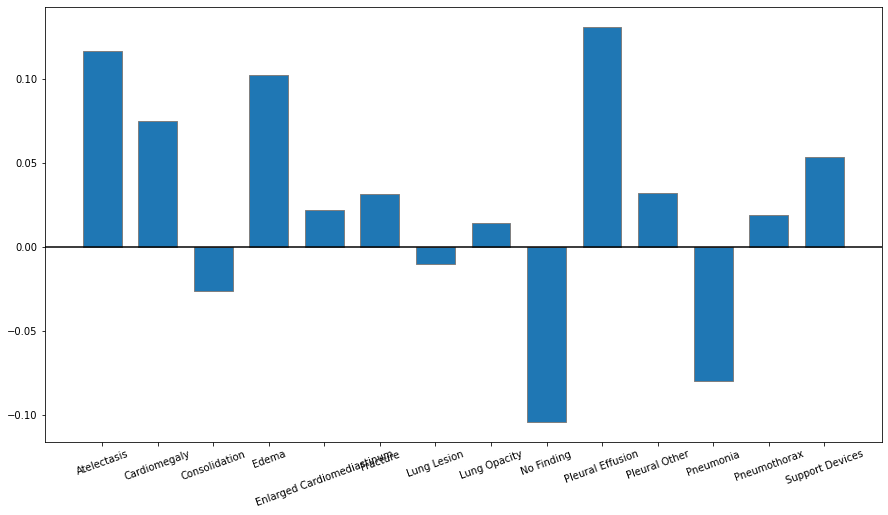

In [84]:
fig, ax = plt.subplots(figsize =(15, 8))
plt.axhline(y=0, c="black")
plt.bar(np.arange(0, len(corr_dict)*2, 2), corr_dict.values(), width=1.4, edgecolor ='grey')
plt.xticks(np.arange(0, len(corr_dict)*2, 2), corr_dict.keys(),
       rotation=20)
plt.show()